In [4]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from astroNN.nn.layers import MCDropout

In [5]:
model = tf.keras.models.load_model('models/FFNN_Hz.h5')
ffnn_do = tf.keras.models.load_model('models/FFNN+MC-DO_Hz.h5', custom_objects={'MCDropout': MCDropout})

In [6]:
file = 'data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
z = data.values[:,0]
y = data.values[:,1:]
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
# z = scalerz.transform(z.reshape(-1,1))

StandardScaler()

## First, we predict at the same redshifts than within the original dataset.

In [50]:
r = scalerz.transform(z.reshape(-1, 1))
pred_random = model.predict(r)

(0.0, 2.065)

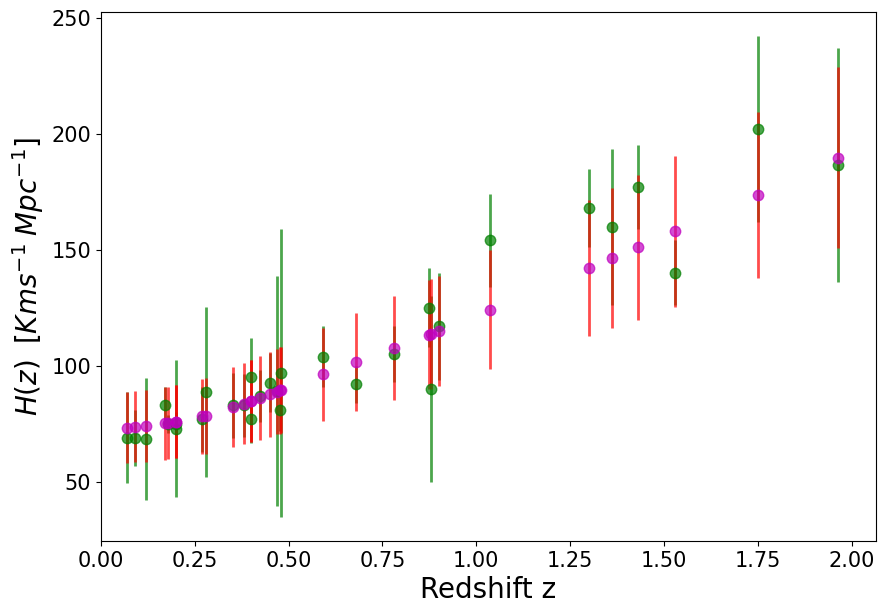

In [51]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.7, elinewidth=2)
plt.errorbar(z, pred_random[:,0], pred_random[:,1], markersize=15, fmt='.', 
             ecolor='r', capthick=2, elinewidth=2, alpha=0.7, c='m')

plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.text( 0.1, 280, "$MSE_{val} =  634.5$", fontsize=20 )
# plt.text( 0.1, 240, "$\Delta MSE_{val} = 54.0$", fontsize=20 )
plt.ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
plt.xlim(0, max(z)+0.1)

In [37]:
test_batch_size = len(z)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(z.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

(0.0, 2.065)

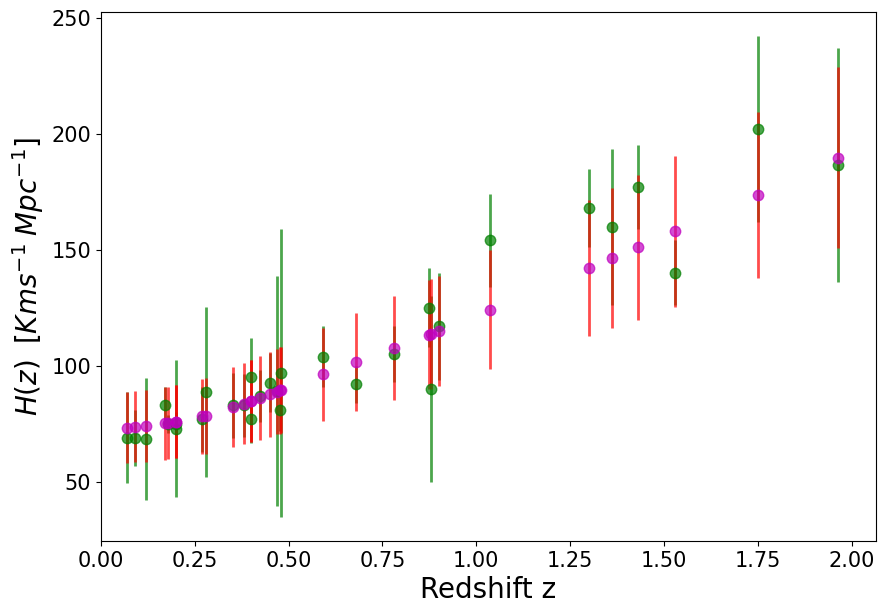

In [48]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.7, elinewidth=2)

# plt.errorbar(z, pred_random[:,0], pred_random[:,1], markersize=15, fmt='.', 
#              ecolor='r', capthick=2, elinewidth=2, alpha=0.5, c='m')

sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)
plt.errorbar(z, prediction_mc_dropout[:,0], yerr=sigma, markersize=15, fmt='.', 
             ecolor='r', capthick=2, elinewidth=2, alpha=0.7, c='m',
             label='Synthetic data with $\sigma$')
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.text( 0.1, 280, "$MSE_{val} =  634.5$", fontsize=20 )
# plt.text( 0.1, 240, "$\Delta MSE_{val} = 54.0$", fontsize=20 )
plt.ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
plt.xlim(0, max(z)+0.1)

## Now, we predict more interpolated points to display a nice $H(z)$ reconstruction

In [44]:
ranz = np.linspace(0, 2.2, 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))

(0.0, 2.065)

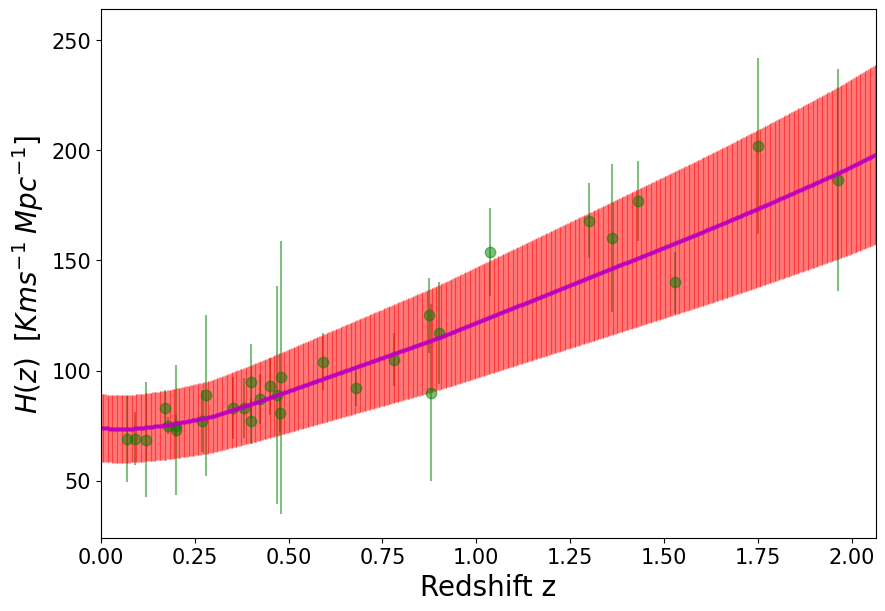

In [45]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(ranz, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m')
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.text( 0.1, 280, "$MSE_{val} =  634.5$", fontsize=20 )
# plt.text( 0.1, 240, "$\Delta MSE_{val} = 54.0$", fontsize=20 )
plt.ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
plt.xlim(0, max(z)+0.1)